# Filtering Foursquare Data

In this notebook we process a full data set with Foursquare venues and check-ins. It's [available here](https://sites.google.com/site/yangdingqi/home/foursquare-dataset). We keep only the venues and check-ins within our areas of interest defined in the previous notebook.

## Preamble

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(context='notebook', font='Lucida Sans Unicode', style='white', palette='plasma')

In [2]:
import pandas as pd
import geopandas as gpd

We use `dask.dataframe` to process huge text files.

In [53]:
import dask.dataframe as dd

Here we load the results of the previous notebook.

In [3]:
areas = gpd.read_file('output/santiago_relevant_area.geo.json')

In [4]:
grid = gpd.read_file('output/santiago_relevant_grid.geo.json')

In [5]:
bbox = areas.total_bounds
bbox

array([-70.9678545, -33.7540753, -70.1758683, -33.0969351])

## Venue Processing

Here we analyze venues (or Points of Interest). 

In [6]:
import pyarrow
print(pyarrow.__version__)
pois = pd.read_csv('4sq_2019/raw_POIs.txt', sep='\t', names=['venue_id', 'lat', 'lon', 'category', 'country']) # dd.read_csv is not working with the current version of pyarrow

19.0.0


In [7]:
pois.head()

,venue_id,lat,lon,category,country
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US


In [8]:
pois_in_bbox = pois[pois.lon.between(bbox[0], bbox[2]) & pois.lat.between(bbox[1], bbox[3])]
pois_in_bbox.sample(5)

,venue_id,lat,lon,category,country
9586111,511e115de4b06f58443501ea,-33.416389,-70.760013,Bus Line,CL
10667496,51eb99ca498e264122bc16b2,-33.434613,-70.616611,Residential Building (Apartment / Condo),CL
328538,4b5f719af964a520a7ba29e3,-33.402337,-70.576987,Furniture / Home Store,CL
9046209,50ce39dde4b06fef2d95d1c4,-33.453590,-70.657082,Pool,CL
6398865,4f8073f5e4b09a1476c9e366,-33.582790,-70.648430,Farmers Market,CL


In [12]:
len(pois_in_bbox)

95670

Text(0.5, 0, '# of Venues (POIs)')

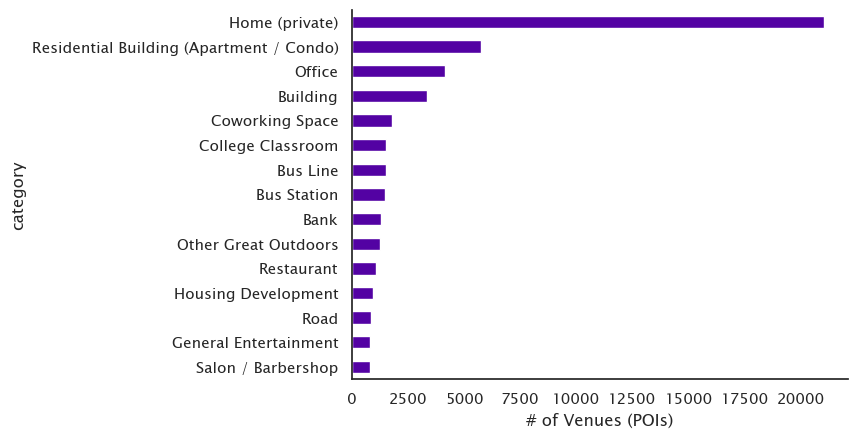

In [9]:
ax = pois_in_bbox.category.value_counts().head(15).sort_values().plot(kind='barh')
sns.despine(ax=ax)
ax.set_xlabel('# of Venues (POIs)')

<Axes: >

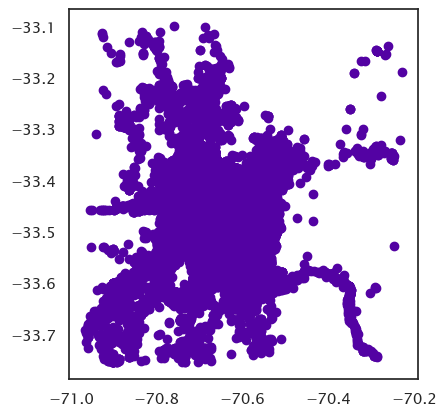

In [10]:
pois_gdf = gpd.GeoDataFrame(pois_in_bbox[['venue_id', 'category']],
                            geometry=gpd.points_from_xy(pois_in_bbox.lon, pois_in_bbox.lat),
                            crs=areas.crs)
pois_gdf.plot()

In [11]:
pois_gdf

,venue_id,category,geometry
109597,4af8ffeaf964a520cd1022e3,Other Great Outdoors,POINT (-70.66046 -33.44616)
222118,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738)
222614,4b44abe7f964a5201ef925e3,Sushi Restaurant,POINT (-70.57765 -33.41222)
222624,4b44ad89f964a52040f925e3,Office,POINT (-70.57276 -33.40448)
222705,4b44b566f964a5200efa25e3,Sandwich Place,POINT (-70.62263 -33.43098)
...,...,...,...
11179377,52e8241811d24e40d89978d0,Home (private),POINT (-70.60383 -33.47606)
11179605,52e8d7ad498e459461a0b33b,Bus Line,POINT (-70.72786 -33.42376)
11179962,52e90de1498ed1ed01b47aaf,Bus Line,POINT (-70.84306 -33.44869)
11179993,52e912e9498ed5442c097af5,Campaign Office,POINT (-70.61707 -33.39269)


In [12]:
pois_gdf_amb = gpd.sjoin(pois_gdf, grid[['geometry',]], predicate='within', how='inner')
pois_gdf_amb

,venue_id,category,geometry,index_right
109597,4af8ffeaf964a520cd1022e3,Other Great Outdoors,POINT (-70.66046 -33.44616),2709
222118,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),1300
222614,4b44abe7f964a5201ef925e3,Sushi Restaurant,POINT (-70.57765 -33.41222),2980
222624,4b44ad89f964a52040f925e3,Office,POINT (-70.57276 -33.40448),1471
222705,4b44b566f964a5200efa25e3,Sandwich Place,POINT (-70.62263 -33.43098),2963
...,...,...,...,...
11179377,52e8241811d24e40d89978d0,Home (private),POINT (-70.60383 -33.47606),2760
11179605,52e8d7ad498e459461a0b33b,Bus Line,POINT (-70.72786 -33.42376),2838
11179962,52e90de1498ed1ed01b47aaf,Bus Line,POINT (-70.84306 -33.44869),1954
11179993,52e912e9498ed5442c097af5,Campaign Office,POINT (-70.61707 -33.39269),2978


<Axes: >

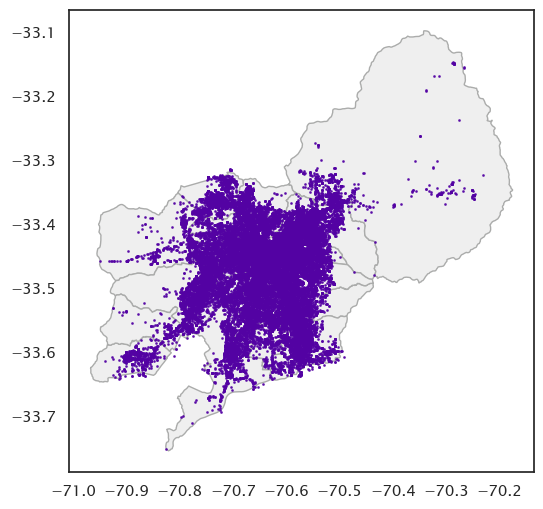

In [13]:
ax = areas.plot(figsize=(16, 6), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
pois_gdf_amb.plot(ax=ax, markersize=1, alpha=0.8)

The POIs in the Santiago grid are joined with the geometry of the Santiago municipalities, then the duplicates resulting from the join are removed (each venue should appear only once in the dataframe), obtaining the POIs within the geometry obtained in the previous notebook.

In [25]:
pois_grid = gpd.sjoin(pois_gdf, grid[['geometry','h3_cellid']], predicate='within', how='inner')
pois_in_grid = pois_grid.groupby('venue_id', group_keys=False).first().reset_index()
pois_in_grid

,venue_id,category,geometry,index_right,h3_cellid
0,4af8ffeaf964a520cd1022e3,Other Great Outdoors,POINT (-70.66046 -33.44616),2709,88b2c55417fffff
1,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),1300,88b2c51831fffff
2,4b44abe7f964a5201ef925e3,Sushi Restaurant,POINT (-70.57765 -33.41222),2980,88b2c556d3fffff
3,4b44ad89f964a52040f925e3,Office,POINT (-70.57276 -33.40448),1471,88b2c519e7fffff
4,4b44b566f964a5200efa25e3,Sandwich Place,POINT (-70.62263 -33.43098),2963,88b2c556abfffff
...,...,...,...,...,...
92226,52e8241811d24e40d89978d0,Home (private),POINT (-70.60383 -33.47606),2760,88b2c5549bfffff
92227,52e8d7ad498e459461a0b33b,Bus Line,POINT (-70.72786 -33.42376),2838,88b2c5555dfffff
92228,52e90de1498ed1ed01b47aaf,Bus Line,POINT (-70.84306 -33.44869),1954,88b2c5435bfffff
92229,52e912e9498ed5442c097af5,Campaign Office,POINT (-70.61707 -33.39269),2978,88b2c556cdfffff


In [26]:
pois_in_grid.head()

,venue_id,category,geometry,index_right,h3_cellid
0,4af8ffeaf964a520cd1022e3,Other Great Outdoors,POINT (-70.66046 -33.44616),2709,88b2c55417fffff
1,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),1300,88b2c51831fffff
2,4b44abe7f964a5201ef925e3,Sushi Restaurant,POINT (-70.57765 -33.41222),2980,88b2c556d3fffff
3,4b44ad89f964a52040f925e3,Office,POINT (-70.57276 -33.40448),1471,88b2c519e7fffff
4,4b44b566f964a5200efa25e3,Sandwich Place,POINT (-70.62263 -33.43098),2963,88b2c556abfffff


In [27]:
grid_n_pois = pois_in_grid.groupby('index_right').size()
grid_n_pois.name = 'poi_count'

c:\Users\sebam\miniconda3\envs\multisource-flows\Lib\site-packages\geopandas\plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


Text(0.5, 1.0, '# of POIs in the Santiago Metropolitan Area (Foursquare data)')

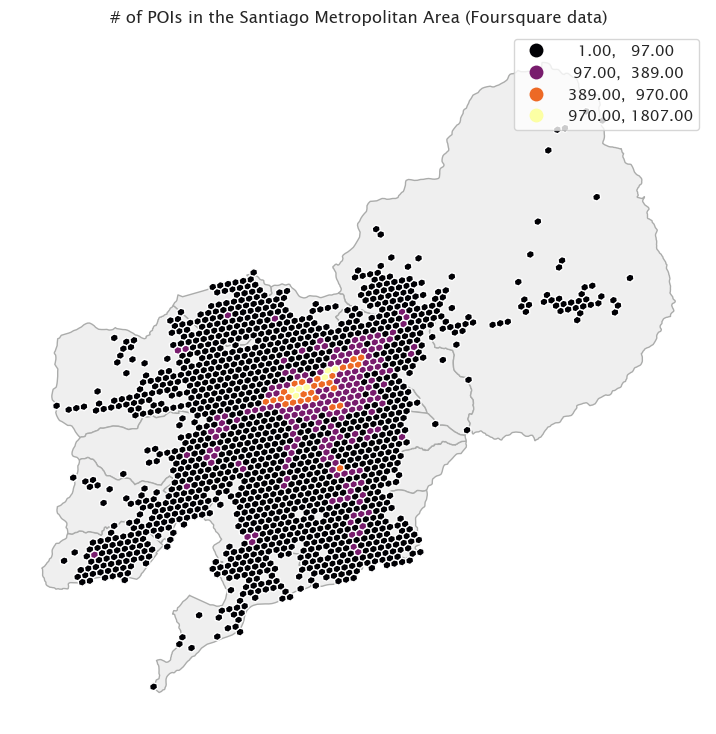

In [17]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(grid_n_pois).dropna().plot(column='poi_count', cmap='inferno', k=4, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('# of POIs in the Santiago Metropolitan Area (Foursquare data)')

## Check-Ins

In [18]:
check_ins = pd.read_csv('4sq_2019/raw_Checkins_anonymized.txt', sep='\t', names=['user_id', 'venue_id', 'datetime', 'utc_offset']) # dd.read_csv is not working with the current version of pyarrow
check_ins.head()

,user_id,venue_id,datetime,utc_offset
0,546830,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,2277773,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,1139878,4d9254ef62ad5481fa6e6a4b,Tue Apr 03 18:00:08 +0000 2012,-180


In [19]:
amb_check_ins = check_ins[check_ins.venue_id.isin(pois_in_grid.venue_id)]
amb_check_ins.shape

(1307956, 4)

In [29]:
amb_check_ins.head()

,user_id,venue_id,datetime,utc_offset
56,44093,4dc0367c6a23e5a549e68d9b,Tue Apr 03 18:00:22 +0000 2012,-180
82,980044,4bb8ddd31261d13ab608e998,Tue Apr 03 18:00:27 +0000 2012,-180
83,640995,4f7200c9e4b0e30fde677e23,Tue Apr 03 18:00:28 +0000 2012,-180
179,969261,4d386aa93ffba1433b405c56,Tue Apr 03 18:00:55 +0000 2012,-180
180,1424666,4b6f2cf8f964a52013e22ce3,Tue Apr 03 18:00:55 +0000 2012,-180


In [30]:
user_counts = amb_check_ins.user_id.value_counts()
user_counts.describe()

count    41112.000000
mean        31.814458
std         73.399565
min          1.000000
25%          2.000000
50%          8.000000
75%         29.000000
max       2943.000000
Name: count, dtype: float64

In [31]:
venue_counts = amb_check_ins.venue_id.value_counts()
venue_counts.name = 'popularity'
venue_counts.describe()

count    92231.000000
mean        14.181306
std        100.113770
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max      17293.000000
Name: popularity, dtype: float64

In [32]:
venues = pois_gdf_amb.join(venue_counts, on='venue_id').dropna()
venues.shape, pois_gdf_amb.shape

((92231, 5), (92231, 4))

In [33]:
venues.groupby('index_right')['popularity'].sum()

index_right
9         4
113       1
232      16
239      13
246       1
       ... 
3995    442
3996    857
3997     48
3998    159
3999    100
Name: popularity, Length: 1571, dtype: int64

In [34]:
top_popular = venues.sort_values('popularity', ascending=False).head(15)#.to_text()

Text(0.5, 0, 'Popularity')

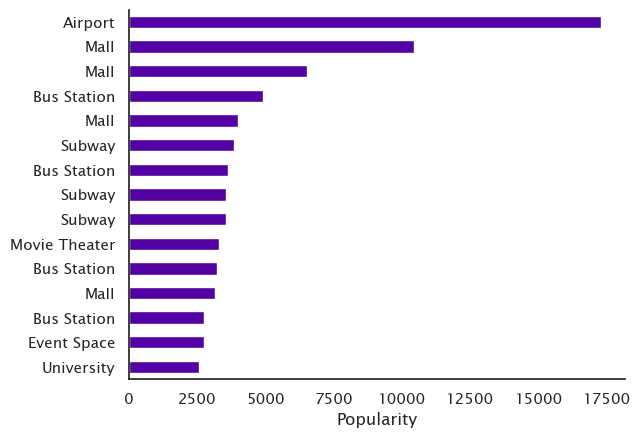

In [35]:
ax = top_popular[['category', 'popularity']].set_index('category').popularity.sort_values(ascending=True).plot(kind='barh', legend=False)
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Popularity')

c:\Users\sebam\miniconda3\envs\multisource-flows\Lib\site-packages\geopandas\plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


Text(0.5, 1.0, 'Popularity of Cells in the Santiago Metropolitan Area (Foursquare data)')

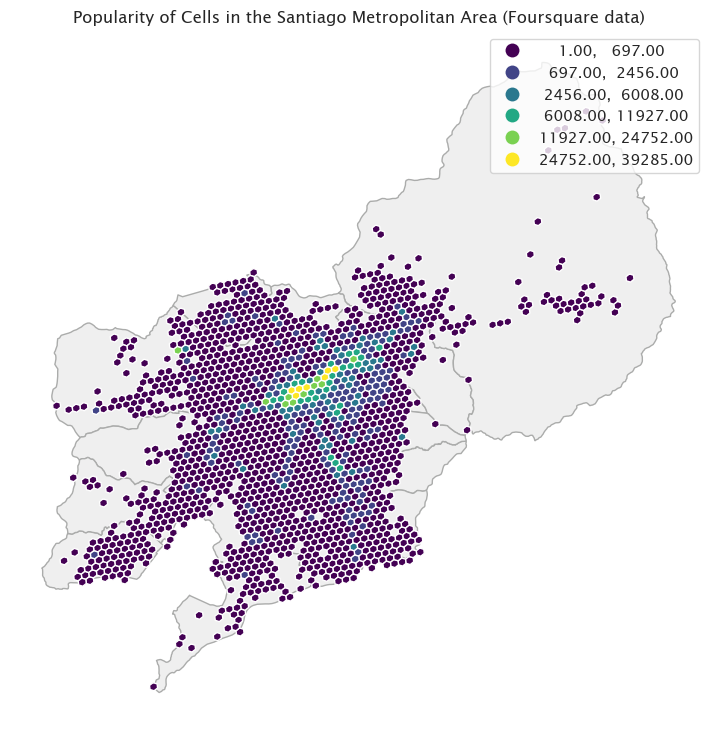

In [36]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(venues.groupby('index_right')['popularity'].sum()).dropna().plot(column='popularity', k=6, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('Popularity of Cells in the Santiago Metropolitan Area (Foursquare data)')

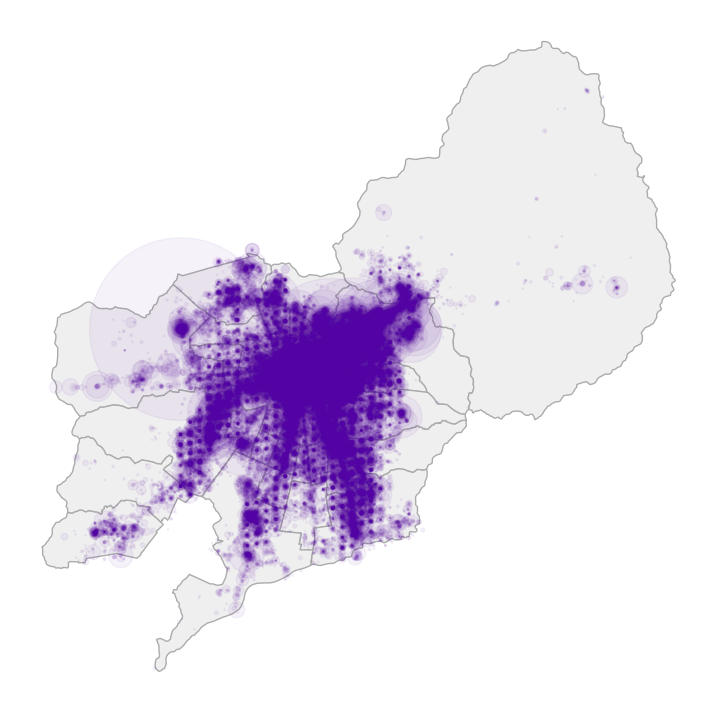

In [37]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
venues.plot(ax=ax, alpha=0.05, markersize='popularity')
ax.set_axis_off()

## Data Export

Here we save the relevant information, i.e., venues and check-ins in the areas of interest.

In [38]:
amb_check_ins.to_csv('output/santiago_relevant_check_ins.csv.gz')

In [39]:
pois_in_grid.to_file('output/santiago_relevant_pois.json', driver='GeoJSON')

c:\Users\sebam\miniconda3\envs\multisource-flows\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
